In [0]:
# !cd /content
# !pwd
# !ls /content

In [0]:
# !pip install jieba
# !pip install gensim
!nvidia-smi

Thu Dec 26 08:56:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# import pdb

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

data_root = '/gdrive/My Drive/data_tf'
# Above is for notebook only
# Below is to be moved to py files
! ls '/gdrive/My Drive/python-code/文本摘要-01'
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
checkpoints  utils			     work-tf-unigru-attn.ipynb
data	     work.ipynb			     work-tf-unigru-attn-pgn.ipynb
result	     work-tf-unigru-attn-beam.ipynb
TensorFlow 2.x selected.


# 上面是测试用
# ============================================================
# 下面要转移到文件里面

# 以下是tensorflow实现带attention 的seq2seq=============

# 下面这部分是整理后保存到py文件

In [0]:
# import modules
import os
import sys
import pathlib
import pandas as pd
import numpy as np
import pdb
import time
import tensorflow as tf

project_root = pathlib.Path(r'/gdrive/My Drive/python-code/文本摘要-01')
sys.path.append(str(project_root))

from utils.config import *
from utils.multi_proc_utils import *
from utils.data_loader import *
from utils.file_utils import *
from utils.data_preprocessor import *


In [0]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred, padding_mask):
    loss = 0
    for t in range(real.shape[1]):
        loss_ = loss_object(real[:, t], pred[:, t, :])
        mask = tf.cast(padding_mask[:, t], dtype=loss_.dtype)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_ = tf.reduce_mean(loss_)  # batch-wise
        loss += loss_
    return loss / real.shape[1]

def calc_loss(real, pred, padding_mask, attentions, cov_loss_wt, use_coverage):
    if use_coverage:
        log_loss = loss_function(real, pred, padding_mask)
        cov_loss = _coverage_loss(attentions, padding_mask)
        return log_loss + cov_loss_wt * cov_loss, log_loss, cov_loss
    else:
        return loss_function(real, pred, padding_mask), 0, 0

def pgn_log_loss_function(real, final_dists, padding_mask):
    # Calculate the loss per step
    # This is fiddly; we use tf.gather_nd to pick out the probabilities of the gold target words
    loss_per_step = []  # will be list length max_dec_steps containing shape (batch_size)
    batch_nums = tf.range(0, limit=real.shape[0])  # shape (batch_size)
    for dec_step, dist in enumerate(final_dists):
        # The indices of the target words. shape (batch_size)
        targets = real[:, dec_step]
        indices = tf.stack((batch_nums, targets), axis=1)  # shape (batch_size, 2)
        gold_probs = tf.gather_nd(dist, indices)  # shape (batch_size). prob of correct words on this step
        losses = -tf.math.log(gold_probs)
        loss_per_step.append(losses)
    # Apply dec_padding_mask and get loss
    _loss = _mask_and_avg(loss_per_step, padding_mask)
    return _loss


def _mask_and_avg(values, padding_mask):
    """Applies mask to values then returns overall average (a scalar)

    Args:
      values: a list length max_dec_steps containing arrays shape (batch_size).
      padding_mask: tensor shape (batch_size, max_dec_steps) containing 1s and 0s.

    Returns:
      a scalar
    """
    padding_mask = tf.cast(padding_mask, dtype=values[0].dtype)
    dec_lens = tf.reduce_sum(padding_mask, axis=1)  # shape batch_size. float32
    values_per_step = [v * padding_mask[:, dec_step] for dec_step, v in enumerate(values)]
    values_per_ex = sum(values_per_step) / dec_lens  # shape (batch_size); normalized value for each batch member
    return tf.reduce_mean(values_per_ex)  # overall average


def _coverage_loss(attn_dists, padding_mask):
    """Calculates the coverage loss from the attention distributions.

    Args:
      attn_dists: The attention distributions for each decoder timestep. A list length max_dec_steps containing shape (batch_size, attn_length)
      padding_mask: shape (batch_size, max_dec_steps).

    Returns:
      coverage_loss: scalar
    """
    coverage = tf.zeros_like(attn_dists[0])  # shape (batch_size, attn_length). Initial coverage is zero.
    covlosses = []  # Coverage loss per decoder timestep. Will be list length max_dec_steps containing shape (batch_size).
    for a in attn_dists:
        covloss = tf.reduce_sum(tf.minimum(a, coverage), [1])  # calculate the coverage loss for this step
        covlosses.append(covloss)
        coverage += a  # update the coverage vector
    coverage_loss = _mask_and_avg(covlosses, padding_mask)
    return coverage_loss


In [0]:


class UnidirGruEncoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, word_matrix, enc_units, batch_sz):
    super(UnidirGruEncoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights = [word_matrix], trainable=False)
    self.gru = tf.keras.layers.GRU(self.enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform')
    
  def initialize_hidden_state(self, batch_size = 0):
    if batch_size == 0:
      batch_size = self.batch_sz
    return tf.zeros((batch_size, self.enc_units))

  def call(self, x, hidden):
    x = self.embedding(x)
    
    output, state = self.gru(x, initial_state = hidden)
    
    return output, state


# TODO: Add bais for it
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.Wc = tf.keras.layers.Dense(units) # this is for coverage
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values, use_coverage, prev_coverage=None):
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    w1 = self.W1(values)

    w2 = self.W2(hidden_with_time_axis)

    sum_w12 = w1 + w2

    if use_coverage and prev_coverage is not None:
      wc = self.Wc(prev_coverage)
      sum_w12 += wc

    aw12 = tf.nn.tanh(sum_w12)

    score = self.V(aw12)

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values

    context_vector = tf.reduce_sum(context_vector, axis=1)

    if use_coverage and prev_coverage is not None:
      coverage = attention_weights
    else:
      coverage = None

    return context_vector, attention_weights, coverage


class UniGruDecoderWithAttention(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, word_matrix, dec_units, batch_sz):
    super(UniGruDecoderWithAttention, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights = [word_matrix], trainable=False)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size, activation=tf.keras.activations.softmax)

    # used for attention
    # self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output, context_vector):
    # enc_output shape == (batch_size, max_length, hidden_size)
    # context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    context_vector = tf.expand_dims(context_vector, 1)

    x = tf.concat([context_vector, x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    prediction = self.fc(output)

    return x, prediction, state

class Pointer(tf.keras.layers.Layer):
  def __init__(self):
    super(Pointer, self).__init__()
    self.w_s_reduce = tf.keras.layers.Dense(1)
    self.w_i_reduce = tf.keras.layers.Dense(1)
    self.w_c_reduce = tf.keras.layers.Dense(1)

  def __call__(self, context_vector, dec_hidden, dec_inp):
    return tf.nn.sigmoid(self.w_s_reduce(dec_hidden) + self.w_c_reduce(context_vector) + self.w_i_reduce(dec_inp))


In [0]:

class PGN(tf.keras.Model):
  def __init__(self, params):
    super(PGN, self).__init__()
    self.working_ds = AutoCarDataSet()
    self.working_ds.prepare_data(force_build=False)
    self.working_ds.get_wv_model(force_build=False)

    # define constants for codec
    self.BUFFER_SIZE = self.working_ds.train_ids_x.shape[0]
    self.BATCH_SIZE = 16
    self.steps_per_epoch = self.working_ds.train_ids_x.shape[0]//self.BATCH_SIZE
    self.embedding_dim = wv_embedding_dim
    self.codec_units = 256
    self.vocab_inp_size = len(self.working_ds.vocab)
    self.vocab_tar_size = self.vocab_inp_size

    self.checkpoint_dir = os.path.join(checkpoint_dir_tf, 'unigru_attn_pgn')
    self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")

    # self.optimizer = tf.keras.optimizers.Adam(1e-3)
    self.optimizer = tf.keras.optimizers.Adagrad(1e-3, 
                initial_accumulator_value=0.1, clipnorm=2.0)

    self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    self.encoder, self.decoder = self.create_codec()

    self.checkpoint = self.def_checkpoint()

    self.dataset = self.get_dataset()

    self.padding_index = self.working_ds.token_id_pad

    self.beam_size = 2

    self.use_pgn = True

    self.use_coverage = True
    self.cov_loss_wt = 0.1

    self.encoder, self.decoder = self.create_codec()

    self.attention = BahdanauAttention(params[self.codec_units])

    self.pointer = Pointer()
  
  def create_codec(self):
    encoder = UnidirGruEncoder(self.vocab_inp_size, self.embedding_dim, self.working_ds.embedding_matrix, self.codec_units, self.BATCH_SIZE)
    decoder = UniGruDecoderWithAttention(self.vocab_tar_size, self.embedding_dim, self.working_ds.embedding_matrix, self.codec_units, self.BATCH_SIZE)
    return encoder, decoder

  def call_encoder(self, enc_inp):
    enc_hidden = self.encoder.initialize_hidden_state()
    enc_output, enc_hidden = self.encoder(enc_inp, enc_hidden)
    return enc_output, enc_hidden

  def call_decoder_one_step(self, dec_input, dec_hidden, enc_output, enc_extended_inp, 
                batch_oov_len, enc_pad_mask, use_coverage, prev_coverage):

    context_vector, attentions, coverage_ret = self.attention(dec_hidden, enc_pad_mask, use_coverage, prev_coverage)

    dec_x, pred, dec_hidden = self.decoder(dec_input, dec_hidden, enc_output, context_vector)

    if self.use_pgn:
      p_gen = self.pointer(context_vector, dec_hidden, tf.squeeze(dec_x, axis=1))

      final_dists = _calc_final_dist(enc_extended_inp, [pred], [attentions], [p_gen],
                       batch_oov_len, self.vocab_inp_size, self.BATCH_SIZE)
      
      return tf.stack(final_dists, 1), dec_hidden, context_vector, attentions, p_gen, coverage_ret
    else:
      return pred, dec_hidden, context_vector, attentions, None, coverage_ret

  def call(self, enc_inp, dec_inp,
       enc_extended_inp, batch_oov_len,
       enc_pad_mask, use_coverage, prev_coverage=None):
    '''
    :param enc_inp:
    :param dec_inp:  tf.expand_dims(dec_inp[:, t], 1)
    :param enc_extended_inp:
    :param batch_oov_len:
    '''
    predictions = []
    attentions = []
    p_gens = []
    coverages = []

    # encoder
    enc_output, enc_hidden = self.call_encoder(enc_inp)

    dec_hidden = enc_hidden

    context_vector, _, coverage_ret = self.attention(dec_hidden,
                             enc_output,
                             enc_pad_mask,
                             use_coverage,
                             prev_coverage)
    for t in range(dec_inp.shape[1]):
      # decoder
      # using teacher forcing
      dec_x, dec_pred, dec_hidden = self.decoder(tf.expand_dims(dec_inp[:, t], 1),
                             dec_hidden,
                             enc_output,
                             context_vector)

      context_vector, attn, coverage_ret = self.attention(dec_hidden,
                                enc_output,
                                enc_pad_mask,
                                use_coverage,
                                coverage_ret)

      p_gen = self.pointer(context_vector, dec_hidden, tf.squeeze(dec_x, axis=1))
      coverages.append(coverage_ret)
      attentions.append(attn)
      predictions.append(dec_pred)
      p_gens.append(p_gen)

    if self.use_pgn:
      final_dists = self._calc_final_dist(enc_extended_inp,
                       predictions,
                       attentions,
                       p_gens,
                       batch_oov_len,
                       self.vocab_inp_size,
                       self.BATCH_SIZE)
      return tf.stack(final_dists, 1), dec_hidden, attentions, tf.stack(p_gens, 1), None
    else:
      return tf.stack(predictions, 1), dec_hidden, attentions, None, None


  def _calc_final_dist(_enc_batch_extend_vocab, vocab_dists, attn_dists, p_gens, batch_oov_len, vocab_size, batch_size):
    """
    Calculate the final distribution, for the pointer-generator model
    Args:
    vocab_dists: The vocabulary distributions. List length max_dec_steps of (batch_size, vsize) arrays.
                The words are in the order they appear in the vocabulary file.
    attn_dists: The attention distributions. List length max_dec_steps of (batch_size, attn_len) arrays
    Returns:
    final_dists: The final distributions. List length max_dec_steps of (batch_size, extended_vsize) arrays.
    """
    # Multiply vocab dists by p_gen and attention dists by (1-p_gen)
    vocab_dists = [p_gen * dist for (p_gen, dist) in zip(p_gens, vocab_dists)]
    attn_dists = [(1 - p_gen) * dist for (p_gen, dist) in zip(p_gens, attn_dists)]

    # Concatenate some zeros to each vocabulary dist, to hold the probabilities for in-article OOV words
    extended_vsize = vocab_size + batch_oov_len  # the maximum (over the batch) size of the extended vocabulary
    extra_zeros = tf.zeros((batch_size, batch_oov_len))
    # list length max_dec_steps of shape (batch_size, extended_vsize)
    vocab_dists_extended = [tf.concat(axis=1, values=[dist, extra_zeros]) for dist in vocab_dists]

    # Project the values in the attention distributions onto the appropriate entries in the final distributions
    # This means that if a_i = 0.1 and the ith encoder word is w, and w has index 500 in the vocabulary,
    # then we add 0.1 onto the 500th entry of the final distribution
    # This is done for each decoder timestep.
    # This is fiddly; we use tf.scatter_nd to do the projection
    batch_nums = tf.range(0, limit=batch_size)  # shape (batch_size)
    batch_nums = tf.expand_dims(batch_nums, 1)  # shape (batch_size, 1)
    attn_len = tf.shape(_enc_batch_extend_vocab)[1]  # number of states we attend over
    batch_nums = tf.tile(batch_nums, [1, attn_len])  # shape (batch_size, attn_len)
    indices = tf.stack((batch_nums, _enc_batch_extend_vocab), axis=2)  # shape (batch_size, enc_t, 2)
    shape = [batch_size, extended_vsize]
    # list length max_dec_steps (batch_size, extended_vsize)
    attn_dists_projected = [tf.scatter_nd(indices, copy_dist, shape) for copy_dist in attn_dists]

    # Add the vocab distributions and the copy distributions together to get the final distributions
    # final_dists is a list length max_dec_steps; each entry is a tensor shape (batch_size, extended_vsize) giving
    # the final distribution for that decoder timestep
    # Note that for decoder timesteps and examples corresponding to a [PAD] token, this is junk - ignore.
    final_dists = [vocab_dist + copy_dist for (vocab_dist, copy_dist) in
                   zip(vocab_dists_extended, attn_dists_projected)]

    return final_dists

  def train_step(self, enc_inp, extended_enc_input, max_oov_len,
           dec_input, dec_target,
           enc_pad_mask, padding_mask):
    # print('************train_step*************')
    with tf.GradientTape() as tape:
      # 逐个预测序列

      final_dists, _, attentions, p_gen, coverages = self.call(enc_inp,
                                 dec_input,
                                 extended_enc_input,
                                 max_oov_len,
                                 enc_pad_mask=enc_pad_mask,
                                 use_coverage=self.use_coverage,
                                 prev_coverage=None)

      batch_loss, log_loss, cov_loss = calc_loss(dec_target, final_dists, padding_mask, attentions,
                             self.cov_loss_wt, self.use_coverage)

    # print('************variables*************')
    variables = self.encoder.trainable_variables + self.decoder.trainable_variables + \
          self.attention.trainable_variables + self.pointer.trainable_variables

    # print('************gradient*************')
    gradients = tape.gradient(batch_loss, variables)

    # print('************optimizer*************')
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss, log_loss, cov_loss

  def train_one_batch(self, encoder, decoder, inp, targ, enc_hidden):
    return train_step(self, enc_inp, extended_enc_input, max_oov_len,
           dec_input, dec_target, enc_pad_mask, padding_mask)

  def train_one_epoch(self, encoder, decoder, dataset):
      enc_hidden = encoder.initialize_hidden_state()
      total_loss = 0.0

      starttime = time.time()
      print('Epoch start time {}'.format(starttime))
      loss_history = []
      for (batch, (inp, targ)) in enumerate(dataset.take(self.steps_per_epoch)):
          batch_loss = self.train_one_batch(encoder, decoder, inp, targ, enc_hidden)
          total_loss += batch_loss

          loss_history.append(batch_loss)

          # if batch == 5:
          #   break

          if (batch+1) % 100 == 0:
              # print('Batch {} time {:.2f}'.format(batch, time.time() - starttime))
              print('Batch {} Loss {:.4f} time {:.2f}'.format(batch+1, batch_loss.numpy(), time.time() - starttime)) #Not valid if @tf.function
      print('Loss at epoch end {:.4f}'.format(total_loss / self.steps_per_epoch)) #Not valid if @tf.function

      return total_loss / self.steps_per_epoch

  def def_checkpoint(self):
      checkpoint = tf.train.Checkpoint(seq2seq=self)
      return checkpoint

  def create_codec(self):
      encoder = UnidirGruEncoder(self.vocab_inp_size, self.embedding_dim, self.working_ds.embedding_matrix, self.codec_units, self.BATCH_SIZE)
      decoder = UniGruDecoderWithAttention(self.vocab_tar_size, self.embedding_dim, self.working_ds.embedding_matrix, self.codec_units, self.BATCH_SIZE)
      return encoder, decoder

  def get_dataset(self):
      dataset = tf.data.Dataset.from_tensor_slices((self.working_ds.train_ids_x, self.working_ds.train_ids_y)).shuffle(self.BUFFER_SIZE)
      dataset = dataset.batch(self.BATCH_SIZE, drop_remainder=True)
      return dataset

  def train_all(self, encoder, decoder, dataset, epochs, save_chkpnts):

      loss_history = []
      for e in range(epochs):
          print('Epoch {} ============================>'.format(e))
          epoch_loss = self.train_one_epoch(encoder, decoder, dataset)
          loss_history.append(epoch_loss)
          
          if save_chkpnts  and (e + 1) % 1 == 0:
              # saving (checkpoint) the model every 2 epochs
              self.checkpoint.save(file_prefix = self.checkpoint_prefix)

      return loss_history

  def train(self, epochs = 1, save_chkpnts = True):
    loss_history = self.train_all(self.encoder, self.decoder, self.dataset, epochs, save_chkpnts)
    self.encoder.summary()
    self.decoder.summary()


In [0]:

class Seq2Seq(tf.keras.Model):
  def __init__(self):
    super(Seq2Seq, self).__init__()
    self.working_ds = AutoCarDataSet()
    self.working_ds.prepare_data(force_build=False)
    self.working_ds.get_wv_model(force_build=False)

    # define constants for codec
    self.BUFFER_SIZE = self.working_ds.train_ids_x.shape[0]
    self.BATCH_SIZE = 16
    self.steps_per_epoch = self.working_ds.train_ids_x.shape[0]//self.BATCH_SIZE
    self.embedding_dim = wv_embedding_dim
    self.codec_units = 256
    self.vocab_inp_size = len(self.working_ds.vocab)
    self.vocab_tar_size = len(self.working_ds.vocab)

    self.checkpoint_dir = os.path.join(checkpoint_dir_tf, 'unigru_attn')
    self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")

    self.optimizer = tf.keras.optimizers.Adam(1e-3)

    self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    self.encoder, self.decoder = self.create_codec()

    self.checkpoint = self.def_checkpoint()

    self.dataset = self.get_dataset()

    self.padding_index = self.working_ds.token_id_pad

    self.beam_size = 2

  def loss_function(self, real, pred):
      mask = tf.math.logical_not(tf.math.equal(real, self.padding_index))

      loss_ = self.loss_object(real, pred)

      mask = tf.cast(mask, dtype=loss_.dtype)
      loss_ *= mask

      return tf.reduce_mean(loss_)

  def train_one_batch(self, encoder, decoder, inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
      # print('enc_hidden1: ', enc_hidden)
      enc_output, enc_hidden = encoder(inp, enc_hidden)

      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([self.working_ds.token_id_start] * self.BATCH_SIZE, 1)

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += self.loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    zipped_variables = zip(gradients, variables)

    self.optimizer.apply_gradients(zipped_variables)

    return batch_loss

  def train_one_epoch(self, encoder, decoder, dataset):
      enc_hidden = encoder.initialize_hidden_state()
      total_loss = 0.0

      starttime = time.time()
      print('Epoch start time {}'.format(starttime))
      loss_history = []
      for (batch, (inp, targ)) in enumerate(dataset.take(self.steps_per_epoch)):
          batch_loss = self.train_one_batch(encoder, decoder, inp, targ, enc_hidden)
          total_loss += batch_loss

          loss_history.append(batch_loss)

          # if batch == 5:
          #   break

          if (batch+1) % 100 == 0:
              # print('Batch {} time {:.2f}'.format(batch, time.time() - starttime))
              print('Batch {} Loss {:.4f} time {:.2f}'.format(batch+1, batch_loss.numpy(), time.time() - starttime)) #Not valid if @tf.function
      print('Loss at epoch end {:.4f}'.format(total_loss / self.steps_per_epoch)) #Not valid if @tf.function

      return total_loss / self.steps_per_epoch

  def def_checkpoint(self):
      checkpoint = tf.train.Checkpoint(seq2seq=self)
      return checkpoint

  def create_codec(self):
      encoder = UnidirGruEncoder(self.vocab_inp_size, self.embedding_dim, self.working_ds.embedding_matrix, self.codec_units, self.BATCH_SIZE)
      decoder = UniGruDecoderWithAttention(self.vocab_tar_size, self.embedding_dim, self.working_ds.embedding_matrix, self.codec_units, self.BATCH_SIZE)
      return encoder, decoder

  def get_dataset(self):
      dataset = tf.data.Dataset.from_tensor_slices((self.working_ds.train_ids_x, self.working_ds.train_ids_y)).shuffle(self.BUFFER_SIZE)
      dataset = dataset.batch(self.BATCH_SIZE, drop_remainder=True)
      return dataset

  def train_all(self, encoder, decoder, dataset, epochs, save_chkpnts):

      loss_history = []
      for e in range(epochs):
          print('Epoch {} ============================>'.format(e))
          epoch_loss = self.train_one_epoch(encoder, decoder, dataset)
          loss_history.append(epoch_loss)
          
          if save_chkpnts  and (e + 1) % 1 == 0:
              # saving (checkpoint) the model every 2 epochs
              self.checkpoint.save(file_prefix = self.checkpoint_prefix)

      return loss_history

  def train(self, epochs = 1, save_chkpnts = True):
    loss_history = self.train_all(self.encoder, self.decoder, self.dataset, epochs, save_chkpnts)
    self.encoder.summary()
    self.decoder.summary()

  # ====================Below is for beam evalutions====================

  def documents_as_tensor(self, docs):
    newdocs = []
    for i in range(len(docs)):
      doc = sentence_proc(docs[i])
      doc = pad_proc(doc, self.working_ds.X_max_len, self.working_ds.vocab)
      doc = transform_data(doc, self.working_ds.vocab)
      newdocs.append(doc)
    return tf.convert_to_tensor(newdocs)

  #Evaluate in batches
  def evaluate_docs(self, encoder, decoder, docs):

    inputs = self.documents_as_tensor(docs)

    attention_plot = np.zeros((inputs.shape[0], self.working_ds.train_y_max_len, self.working_ds.X_max_len))

    result = [[self.working_ds.token_id_start] for _ in range(inputs.shape[0])]

    hidden = self.encoder.initialize_hidden_state(batch_size = inputs.shape[0])
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden

    start_id = self.working_ds.token_id_start
    dec_input = tf.dtypes.cast(tf.convert_to_tensor((np.ones((inputs.shape[0], 1))*start_id)), tf.int32)

    stop_flags = np.zeros((inputs.shape[0])).astype(bool)
    # pdb.set_trace()
    for t in range(self.working_ds.train_y_max_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        dec_input = np.zeros((inputs.shape[0], 1))
        for i in range(inputs.shape[0]):
          if not stop_flags[i]:
            # storing the attention weights to plot later on
            attention_weight = tf.reshape(attention_weights[i], (-1,))
            attention_plot[i][t] = attention_weight.numpy()

            predicted_id = tf.argmax(predictions[i]).numpy()

            result[i].append(predicted_id)

            if predicted_id == self.working_ds.token_id_stop:
              stop_flags[i] = True

            # the predicted ID is fed back into the model
            dec_input[i][0] = predicted_id

        dec_input = tf.dtypes.cast(tf.convert_to_tensor(dec_input), tf.int32)

        if stop_flags.all():
          break

    return result, inputs, attention_plot

  def train_one_batch_only(self, encoder, decoder, dataset):
    enc_hidden = encoder.initialize_hidden_state()

    inp, targ = next(iter(dataset))
    batch_loss = self.train_one_batch(encoder, decoder, inp, targ, enc_hidden)

    return batch_loss

  def train_one_batch_and_restore_from_checkpoint(self):
    self.train_one_batch_only(self.encoder, self.decoder, self.dataset)
    load_status = self.checkpoint.restore(tf.train.latest_checkpoint(self.checkpoint_dir))
    load_status.assert_consumed()
    print('Succesfully restored from: ', self.checkpoint_dir)
    print(tf.train.latest_checkpoint(self.checkpoint_dir))


Building prefix dict from the default dictionary ...
2019-12-26 08:57:11,991 : DEBUG : Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
2019-12-26 08:57:12,650 : DEBUG : Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.718 seconds.
2019-12-26 08:57:12,714 : DEBUG : Loading model cost 0.718 seconds.
Prefix dict has been built succesfully.
2019-12-26 08:57:12,719 : DEBUG : Prefix dict has been built succesfully.


# 这里是上下分隔符，下面都是测试代码=======================

In [0]:
ss.train(epochs = 5, save_chkpnts = False)

In [0]:
#@title
ss = Seq2Seq()

File read:  /gdrive/My Drive/python-code/文本摘要-01/data/train_seg_data.csv /gdrive/My Drive/python-code/文本摘要-01/data/test_seg_data.csv
sentences_proced train data size 82823,test data size 20000


2019-12-26 09:10:49,436 : INFO : loading Word2Vec object from /gdrive/My Drive/python-code/文本摘要-01/data/wv/word2vec.model


File read:  /gdrive/My Drive/python-code/文本摘要-01/data/merged_train_test_seg_data.csv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-12-26 09:10:50,177 : INFO : loading wv recursively from /gdrive/My Drive/python-code/文本摘要-01/data/wv/word2vec.model.wv.* with mmap=None
2019-12-26 09:10:50,178 : INFO : setting ignored attribute vectors_norm to None
2019-12-26 09:10:50,178 : INFO : loading vocabulary recursively from /gdrive/My Drive/python-code/文本摘要-01/data/wv/word2vec.model.vocabulary.* with mmap=None
2019-12-26 09:10:50,179 : INFO : loading trainables recursively from /gdrive/My Drive/python-code/文本摘要-01/data/wv/word2vec.model.trainables.* with mmap=None
2019-12-26 09:10:50,180 : INFO : setting ignored attribute cum_table to None
2019-12-26 09:10:50,181 : INFO : l

In [0]:
ss.train_one_batch_and_restore_from_checkpoint()

Succesfully restored from:  /gdrive/My Drive/python-code/文本摘要-01/checkpoints/tf/unigru_attn
/gdrive/My Drive/python-code/文本摘要-01/checkpoints/tf/unigru_attn/ckpt-15


In [0]:
train_df = pd.read_csv(train_data_path )
test_df = pd.read_csv(test_data_path )

In [0]:
from datetime import datetime, date

def automaster_test_reader(batch_size, test_df):
  for idx in range(0, test_df.shape[0], batch_size):
    docs = []
    idxs = []
    for i in range(idx, idx + batch_size):
      if i >= test_df.shape[0]:
        break
      doc = ' '.join([test_df['Question'].iloc[i], test_df['Dialogue'].iloc[i]])
      docs.append(doc)
      idxs.append(i)
    yield idxs, docs

def evaluate_all_test_attn():
  # pdb.set_trace()
  result_path = os.path.join(save_result_dir, 'tf', 'unigru-attn', 'result-unigru-attn' + str(date.today()) + '-' + datetime.now().strftime("%H-%M-%S") + '.csv')
  print(result_path)

  test_batch_size = 64
  starttime = time.time()
  with open(result_path, mode='wt') as f:
    f.write('QID,Prediction\n')
    batch_count = 0
    for idxs, docs in automaster_test_reader(test_batch_size, test_df):
      (result, inputs, attention_plot) = ss.evaluate_docs(ss.encoder, ss.decoder, docs)

      for i in range(len(result)):
        res_str = test_df['QID'].iloc[idxs[i]] + ',' + ss.working_ds.tokens_to_texts(result[i]).replace(' ', '') + '\n'
        f.write(res_str)
      
      batch_count += 1

      if (batch_count * test_batch_size) % 128 == 0:
        print('processed: {}, at time: {:.2f}'.format(batch_count * test_batch_size, time.time() - starttime ))

def evaluate_all_test_beam():
  # pdb.set_trace()
  result_path = os.path.join(save_result_dir, 'tf', 'unigru-attn-beam', 'result-unigru-attn-beam' + str(date.today()) + '-' + datetime.now().strftime("%H-%M-%S") + '.csv')
  print(result_path)

  test_batch_size = 1
  starttime = time.time()
  with open(result_path, mode='wt') as f:
    f.write('QID,Prediction\n')
    batch_count = 0
    for idxs, docs in automaster_test_reader(test_batch_size, test_df):
      result, results = ss.evaluate_beam(ss.encoder, ss.decoder, docs)

      res_str = test_df['QID'].iloc[idxs[0]] + ',' + ss.working_ds.tokens_to_texts(result[1:]).replace(' ', '') + '\n'
      f.write(res_str)

      batch_count += 1

      if (batch_count * test_batch_size) % 32 == 0:
        print('processed: {}, at time: {:.2f}'.format(batch_count * test_batch_size, time.time() - starttime ))


evaluate_all_test_attn()

# idx = 2502
# doc = ' '.join([test_df['Question'].iloc[idx], test_df['Dialogue'].iloc[idx]])
# # doc = '机油'
# print(doc)
# # pdb.set_trace()
# # (result, inputs, attention_plot) = ss.evaluate(ss.encoder, ss.decoder, doc)
# (result, topks) = ss.evaluate_beam(doc)
# pdb.set_trace()
# print(result)

# print(ss.working_ds.tokens_to_texts(result))

# print(ss.working_ds.tokens_to_texts(topks[0][1:]))
# print(ss.working_ds.tokens_to_texts(topks[1][1:]))
# print(ss.working_ds.tokens_to_texts(topks[2][1:]))


/gdrive/My Drive/python-code/文本摘要-01/result/tf/unigru-attn/result-unigru-attn2019-12-26-09-06-45.csv
processed: 128, at time: 5.70
processed: 256, at time: 10.86
processed: 384, at time: 15.61
processed: 512, at time: 21.07


KeyboardInterrupt: ignored

In [0]:
tf.expand_dims([ss.working_ds.vocab['<START>']], 0)

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[31810]], dtype=int32)>

In [0]:
print(ss.encoder.trainable_variables)

In [0]:
ss.checkpoint.save_counter

<tf.Variable 'save_counter:0' shape=() dtype=int64, numpy=2>

In [0]:
docs = []
idx = 2502
for i in range(idx, idx+4):
  doc = ' '.join([test_df['Question'].iloc[i], test_df['Dialogue'].iloc[i]])
  docs.append(doc)
# doc = '机油'
print(docs)
# pdb.set_trace()
# (result, inputs, attention_plot) = ss.evaluate(ss.encoder, ss.decoder, doc)
(result, inputs, attention_plot) = ss.evaluate_docs(ss.encoder, ss.decoder, docs)
for r in result:
  print(r)


In [0]:
print(result[3])

不 超过 80 码 ， 车速 不要 超过 80 码 ， 车速 不要 超过 80 码 ， 车速 不要 超过 80 码 ， 车速 不要 超过 80 码 ， 车速 不要 超过 80 码 ， 车速 不要 超过 80 


In [0]:
idx = 2502
doc = ' '.join([test_df['Question'].iloc[idx], test_df['Dialogue'].iloc[idx]])
# doc = '机油'
print(doc)
# pdb.set_trace()
# (result, inputs, attention_plot) = ss.evaluate(ss.encoder, ss.decoder, doc)
(result, inputs, attention_plot) = ss.evaluate(ss.encoder, ss.decoder, doc)
print(result)

福特翼虎1.6T更换正时皮带，因为没有专用工具，想知道怎么精确找出曲轴1缸上支点，怎么固定？凸轮轴我对的末端的卡槽这样会有问题吗？急！急！急！ 技师说：您好，需要使用专用工具装配。曲轴的位置需要一个专用螺丝拧进去，然后顶住曲轴的位置就可以了。|技师说：凸轮轴后面的卡槽需要与缸盖的平面边缘平齐就可以了。|车主说：这车的变速箱油得加多少升？没有用机器，直接放的没有起车排油，|技师说：如果采用重力更换需要五升。
需要 使用 专用工具 安装 。 专用工具 ， 需要 专用工具 ， 需要 专用工具 ， 需要 专用工具 ， 需要 专用工具 ， 需要 专用工具 ， 需要 专用工具 ， 需要 专用工具 ， 需要 专用工具 ， 需要 专用工具 ， 需要 专用工具 ， 需要 专用工具 


In [0]:
from datetime import datetime, date
result_path = os.path.join(save_result_dir, 'tf', 'unigru-attn', 'result-' + str(date.today()) + '-' + datetime.now().strftime("%H-%M-%S") + '.csv')
print(result_path)

eval_batch_size = 64
starttime = time.time()
with open(result_path, mode='wt') as f:
  f.write('QID,Prediction\n')
  for idx in range(0, test_df.shape[0], eval_batch_size):
    docs = []
    for i in range(idx, idx + eval_batch_size):
      if i >= test_df.shape[0]:
        break
      doc = ' '.join([test_df['Question'].iloc[i], test_df['Dialogue'].iloc[i]])
      docs.append(doc)

    (result, inputs, attention_plot) = ss.evaluate_docs(ss.encoder, ss.decoder, docs)

    for i in range(idx, idx + eval_batch_size):
      if i >= test_df.shape[0]:
        break
      res_str = test_df['QID'].iloc[i] + ',' + result[i - idx].replace(' ', '') + '\n'
      f.write(res_str)

    if (idx + 0) % 128 == 0:
      print('processed: {}, at time: {:.2f}'.format(idx + 0, time.time() - starttime ))

/gdrive/My Drive/python-code/文本摘要-01/result/tf/unigru-attn/result-2019-12-24-04-31-59.csv
processed: 0, at time: 4.92
processed: 128, at time: 14.77
processed: 256, at time: 24.71
processed: 384, at time: 34.64
processed: 512, at time: 44.54
processed: 640, at time: 54.50
processed: 768, at time: 64.74
processed: 896, at time: 74.68
processed: 1024, at time: 84.59
processed: 1152, at time: 94.49
processed: 1280, at time: 104.31
processed: 1408, at time: 114.27
processed: 1536, at time: 124.22
processed: 1664, at time: 134.82
processed: 1792, at time: 144.83
processed: 1920, at time: 154.95
processed: 2048, at time: 164.83
processed: 2176, at time: 174.85
processed: 2304, at time: 184.82
processed: 2432, at time: 194.95
processed: 2560, at time: 204.88
processed: 2688, at time: 214.83
processed: 2816, at time: 224.77
processed: 2944, at time: 234.81
processed: 3072, at time: 244.73
processed: 3200, at time: 254.64
processed: 3328, at time: 264.60
processed: 3456, at time: 274.44
process

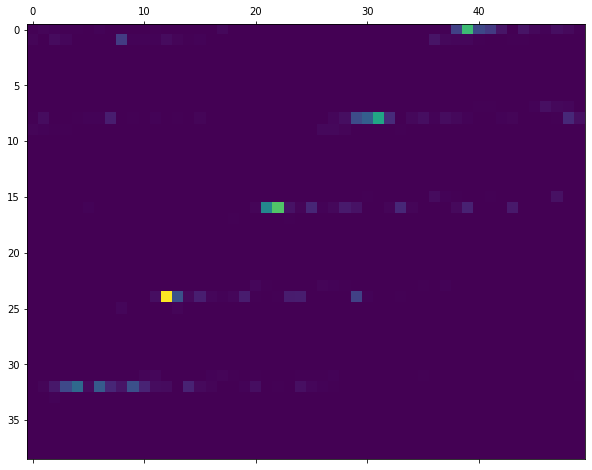

In [0]:
attention_plot.resize(39, 50)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention_plot, cmap='viridis')


In [0]:
from datetime import datetime, date
result_path = os.path.join(save_result_dir, 'tf', 'unigru-attn', 'result-' + str(date.today()) + '-' + datetime.now().strftime("%H-%M-%S") + '.csv')
print(result_path)

starttime = time.time()
with open(result_path, mode='wt') as f:
  f.write('QID,Prediction\n')
  for idx in range(test_df.shape[0]):
    doc = ' '.join([test_df['Question'].iloc[idx], test_df['Dialogue'].iloc[idx]])
    (result, inputs, attention_plot) = ss.evaluate(ss.encoder, ss.decoder, doc)
    result = test_df['QID'].iloc[idx] + ',' + result.replace(' ', '') + '\n'
    f.write(result)
    if (idx + 1) % 20 == 0:
      print('processed: {}, at time: {:.2f}'.format(idx + 1, time.time() - starttime ))

/gdrive/My Drive/python-code/文本摘要-01/result/tf/unigru-attn/result-2019-12-24-03-02-55.csv
processed: 20, at time: 8.49
processed: 40, at time: 16.96
processed: 60, at time: 25.38
processed: 80, at time: 33.77
processed: 100, at time: 42.23
processed: 120, at time: 50.67


KeyboardInterrupt: ignored

In [0]:
print(result)

这种 情况 分析 下 。 <STOP> 


In [0]:
for i, (k, v) in enumerate(reverse_vocab.items()): 
  if i > 10:
    break
  print(i, (k, v))

0 ('0', 0)
1 ('1', 1)
2 ('2', 2)
3 ('3', 3)
4 ('4', 4)
5 ('5', 5)
6 ('6', 6)
7 ('7', 7)
8 ('8', 8)
9 ('9', 9)
10 ('10', 10)


In [0]:
with open(reverse_vocab_path, "r", encoding='utf-8') as f:
  for line in f:
    print(line)
    pdb.set_trace()

In [0]:
dict = {}
with open(vocab_path, "r", encoding='utf-8') as f:
    for line in f:
        kv = line.strip().split("\t")
        dict[kv[0]] = kv[1]

In [0]:
dict['汽车']

'149'

In [0]:
ss.working_ds.X_max_len

In [0]:
ss.document_as_tensor(doc)

In [0]:
ss.checkpoint_dir, ss.checkpoint_prefix

In [0]:
ss.train_one_batch_for_restore(ss.encoder, ss.decoder, ss.dataset)

In [0]:
ss.encoder.trainable_variables[-1], ss.decoder.trainable_variables[-1]

In [0]:
ss.encoder.trainable_variables[-1], ss.decoder.trainable_variables[-1]

In [0]:
pdb.set_trace()
doc = sentence_proc(doc)
pdb.set_trace()
doc = pad_proc(doc, ss.working_ds.X_max_len, ss.working_ds.vocab)
pdb.set_trace()
doc = transform_data(doc, ss.working_ds.vocab)
pdb.set_trace()
doc = tf.convert_to_tensor([doc])
pdb.set_trace()


In [0]:
ss.working_ds.wv_model.most_similar(positive=['保险杠'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-12-24 01:57:46,364 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('保险杆', 0.6531932353973389),
 ('叶子', 0.6307256817817688),
 ('后杠', 0.62998366355896),
 ('前保', 0.6294050216674805),
 ('前杠', 0.6288645267486572),
 ('中网', 0.6240440607070923),
 ('杠坏', 0.6200419664382935),
 ('龙门架', 0.6071912050247192),
 ('前护杠', 0.6040492057800293),
 ('翼子板', 0.5916516780853271)]

In [0]:
dec_input = tf.expand_dims([ss.working_ds.vocab['<START>']]*16, 1)
print(dec_input.shape)
print()
dec_input = tf.expand_dims([ss.working_ds.vocab['<START>']]*16, 0)
print(dec_input.shape)

(16, 1)

(1, 16)


In [0]:
working_ds = AutoCarDataSet()
working_ds.prepare_data(force_build=False)
working_ds.get_wv_model(force_build=False)


# [baidu](http://www.baidu.com)



In [0]:
encoder, decoder = create_codec()

dataset = get_dataset()
loss_history = train_all(encoder, decoder, dataset, 1, True)
encoder.summary()
decoder.summary()


In [0]:
# !ls '/gdrive/My Drive/python-code/罗杰20191222-2'
!cp -avr '/gdrive/My Drive/python-code/罗杰20191222' '/gdrive/My Drive/python-code/罗杰20191222-2/'

In [0]:
encoder, decoder = create_codec()
train_for_restore(encoder, decoder, get_dataset())

In [0]:
encoder.trainable_variables

In [0]:
sys.path

['/tensorflow-2.1.0/python3.6',
 '',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/gdrive/My Drive/python-code/文本摘要-01',
 '/gdrive/My Drive/python-code/文本摘要-01',
 '/gdrive/My Drive/python-code/文本摘要-01']

In [0]:
print(ss.checkpoint_prefix)
print(ss.checkpoint_dir)
from utils.inspect_checkpoint import call_main

class ParamFlags():
  def __init__(self, file_name):
    self.file_name = file_name
    self.tensor_name = ""
    self.all_tensors = True
    self.all_tensor_names = True
    self.count_exclude_pattern = ""

latest_file_name = os.path.join(ss.checkpoint_dir, 'ckpt-1')
FLAGS = ParamFlags(latest_file_name)
call_main(FLAGS, 'unused')

/gdrive/My Drive/python-code/文本摘要-01/checkpoints/tf/unigru_attn/ckpt
/gdrive/My Drive/python-code/文本摘要-01/checkpoints/tf/unigru_attn
tensor: _CHECKPOINTABLE_OBJECT_GRAPH (string) []
b'\n\x1f\n\x0b\x08\x01\x12\x07seq2seq\n\x10\x08\x02\x12\x0csave_counter\nD\n\r\x08\x03\x12\toptimizer\n\x0b\x08\x04\x12\x07encoder\n\x0b\x08\x05\x12\x07decoder\n\x0c\x12\ncheckpoint\n\x0b\x08\x06\x12\x07dataset\nI\x12G\n\x0eVARIABLE_VALUE\x12\x0csave_counter\x1a\'save_counter/.ATTRIBUTES/VARIABLE_VALUE\n\xbc\x02\n\x08\x08\x07\x12\x04iter\n\n\x08\x08\x12\x06beta_1\n\n\x08\t\x12\x06beta_2\n\t\x08\n\x12\x05decay\n\x11\x08\x0b\x12\rlearning_rate\x1a\x07\x08\x19\x12\x01m\x18*\x1a\x07\x08\x1a\x12\x01m\x18+\x1a\x07\x08\x1e\x12\x01m\x18,\x1a\x07\x08\x1f\x12\x01m\x18-\x1a\x07\x08 \x12\x01m\x18.\x1a\x07\x08!\x12\x01m\x18/\x1a\x07\x08"\x12\x01m\x180\x1a\x07\x08#\x12\x01m\x181\x1a\x07\x08$\x12\x01m\x182\x1a\x07\x08%\x12\x01m\x183\x1a\x07\x08&\x12\x01m\x184\x1a\x07\x08\'\x12\x01m\x185\x1a\x07\x08(\x12\x01m\x186\x1a\x07\

In [0]:
checkpoint = def_checkpoint(encoder, decoder, optimizer)

load_status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
load_status.assert_consumed()

In [0]:
decoder.embedding.embeddings

In [0]:
import os
from tensorflow.python import pywrap_tensorflow
# checkpoint_path = os.path.join(model_dir, "model.ckpt")
checkpoint_path = checkpoint_prefix
reader = pywrap_tensorflow.NewCheckpointReader(checkpoint_path)
var_to_shape_map = reader.get_variable_to_shape_map()
for key in var_to_shape_map:
    print("\r\ntensor_name: ", key, end=' ')
    print(reader.get_tensor(key))


In [0]:
load_status.assert_existing_objects_matched()

In [0]:
doc = "更好机油散热器，问题依然没有解决技师说仪表亮红色机油灯？|车主说|车主说滴滴几声恢复正常。请参考原先提问！|技师说到哪去找。|车主说图片|车主说看到？|技师说领驭？|车主说|车主说感觉行驶一段时间后报警。走走停停报警次数增多。|技师说稍|技师说图片|技师说图片|技师说测量一下标准机油压力，压力低需要进行相应检查维修。|车主说凉车机油压力4|车主说热车才1|技师说热车怠速最低1.3|车主说不了1.3|技师说发动机水温？|车主说水温正常|车主说没有测量温度|技师说水温80度机油压力不到1.3，说明卸压，水温90以上，不到1.3说明散热不好。|车主说好|车主说再试试|车主说两种情况处理？|技师说冷车机油粘度大，压力肯定高|车主说两种情况解决？|技师说水温80度，机油压力灯亮，说明机械方面故障，考虑机油泵，限压阀，机油喷嘴，热车机油压力灯亮，重点考虑机油粘度机油散热器，水箱是否堵塞，机油里加注抗磨剂。"
ts = document_as_tensor(doc)
evaluate(encoder, decoder, doc)

In [0]:
ts

In [0]:
decoder = UniGruDecoderWithAttention(vocab_tar_size, embedding_dim, working_ds.embedding_matrix, codec_units, BATCH_SIZE)

sample_decoder_output, state, attention_weights = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)
decoder.summary()
print ('UniGruDecoderWithAttention output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
print ('UniGruDecoderWithAttention state shape: (batch_size, vocab size) {}'.format(state.shape))
print ('UniGruDecoderWithAttention attention_weights shape: (batch_size, vocab size) {}'.format(attention_weights.shape))

In [0]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
attention_layer.summary()

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

In [0]:
21195*300

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((working_ds.train_ids_x, working_ds.train_ids_y)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)
print(example_input_batch)

encoder = UnidirGruEncoder(vocab_inp_size, embedding_dim, working_ds.embedding_matrix, codec_units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

encoder.summary()
print ('ThisEncoder input shape: (batch size, sequence length) {}'.format(example_input_batch.shape))
print ('ThisEncoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('ThisEncoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
print(type(encoder.embedding.embeddings))

In [0]:
# !pip show tensorflow-gpu
# tf.__version__
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
# tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None )

In [0]:
# -*- coding:utf-8 -*-
# Created by Kevin Luo at 2019-12-17
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy


def seq2seq(input_length, output_sequence_length, embedding_matrix, vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], trainable=False,
                        input_length=input_length))
    model.add(Bidirectional(GRU(300, return_sequences=False)))
    model.add(Dense(300, activation="relu"))
    model.add(RepeatVector(output_sequence_length))
    model.add(Bidirectional(GRU(300, return_sequences=True)))
    model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(1e-3))
    model.summary()
    return model


In [0]:
print(working_ds.train_df['X'].iloc[4999])

working_ds.wv_model.most_similar(positive=['语音'], negative=[])

print(working_ds.train_csv)
print(working_ds.test_csv)
        
print(working_ds.train_df.shape)
print(working_ds.test_df.shape)
print(working_ds.merged_df.shape)
        
print(working_ds.train_y_max_len)
        
print(working_ds.X_max_len)
		
print(working_ds.train_X.shape)
print(working_ds.train_Y.shape)
print(working_ds.test_X.shape)

print(working_ds.train_ids_x.shape)
print(working_ds.train_ids_y.shape)
print(working_ds.test_ids_x.shape)
		
print(working_ds.wv_model)
		
print(len(working_ds.vocab))
print(len(working_ds.reverse_vocab))
		
print(working_ds.embedding_matrix.shape)

print(working_ds.train_ids_x.shape)
print(working_ds.train_ids_y.shape)
print(working_ds.test_ids_x.shape)


In [0]:
basic_s2s_model = seq2seq(working_ds.X_max_len, working_ds.train_y_max_len, working_ds.embedding_matrix, len(working_ds.vocab))

basic_s2s_model.fit(working_ds.train_X, working_ds.train_Y, batch_size=32, epochs=1, validation_split=0.2)
basic_s2s_model.save(os.path.join(project_root, r'data\seq2seq_basic_s2s.model'))

In [0]:
working_ds.wv_model.most_similar(positive=[''], negative=[])

In [0]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))